In [16]:
#Load all libraries/frameworks

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, f1_score, precision_score, recall_score)
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [17]:
def load_explore_data(filepath):
    """Load and perform initial exploration of the dataset"""
    print("Loading dataset...")
    df = pd.read_csv(filepath)

    print(f"Dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Basic info
    print("\nDATASET OVERVIEW ")
    print(df.info())
    print("\nFIRST 5 ROWS ")
    display(df.head())

    print("\nSTATISTICAL SUMMARY ")
    display(df.describe())

    # Fraud distribution
    fraud_counts = df['isFraud'].value_counts()
    fraud_percentage = df['isFraud'].mean() * 100
    print(f"\nFRAUD DISTRIBUTION ")
    print(f"Non-Fraud: {fraud_counts[0]:,} ({100-fraud_percentage:.4f}%)")
    print(f"Fraud: {fraud_counts[1]:,} ({fraud_percentage:.4f}%)")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Fraud distribution pie chart
    axes[0].pie(fraud_counts.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.4f%%', startangle=90)
    axes[0].set_title('Fraud vs Non-Fraud Distribution')

    # Transaction type distribution
    df['type'].value_counts().plot(kind='bar', ax=axes[1])
    axes[1].set_title('Transaction Type Distribution')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return df

In [18]:
def comprehensive_data_analysis(df):
    """Comprehensive data cleaning and exploratory data analysis"""
    print("\nDATA CLEANING & EDA ")

    # 1. Missing Values Analysis
    print("\n1. MISSING VALUES ANALYSIS")
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_values,
        'Missing Percentage': missing_percentage
    }).sort_values('Missing Count', ascending=False)

    if missing_values.sum() > 0:
        display(missing_df[missing_df['Missing Count'] > 0])
    else:
        print("✓ No missing values found!")

    # 2. Data Types and Unique Values
    print("\n2. DATA TYPES AND UNIQUE VALUES")
    data_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Unique Values': df.nunique(),
        'Sample Value': [df[col].iloc[0] for col in df.columns]
    })
    display(data_info)

    # 3. Transaction Type vs Fraud Analysis
    print("\n3. TRANSACTION TYPE vs FRAUD ANALYSIS")
    type_fraud_crosstab = pd.crosstab(df['type'], df['isFraud'], margins=True)
    type_fraud_percentage = pd.crosstab(df['type'], df['isFraud'], normalize='index') * 100

    print("Fraud counts by transaction type:")
    display(type_fraud_crosstab)
    print("\nFraud percentage by transaction type:")
    display(type_fraud_percentage)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Fraud by transaction type
    type_fraud_percentage.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Fraud Percentage by Transaction Type')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Amount distribution
    df.boxplot(column='amount', ax=axes[0,1])
    axes[0,1].set_title('Transaction Amount Distribution')
    axes[0,1].set_yscale('log')

    # Fraud vs Non-fraud amount comparison
    fraud_amounts = df[df['isFraud'] == 1]['amount']
    non_fraud_amounts = df[df['isFraud'] == 0]['amount'].sample(len(fraud_amounts))

    axes[1,0].hist([non_fraud_amounts, fraud_amounts], bins=50, alpha=0.7, label=['Non-Fraud', 'Fraud'])
    axes[1,0].set_xlabel('Amount')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Amount Distribution: Fraud vs Non-Fraud')
    axes[1,0].legend()
    axes[1,0].set_xscale('log')

    # Time pattern analysis
    fraud_by_step = df[df['isFraud'] == 1].groupby('step').size()
    axes[1,1].plot(fraud_by_step.index, fraud_by_step.values)
    axes[1,1].set_xlabel('Time Step')
    axes[1,1].set_ylabel('Number of Frauds')
    axes[1,1].set_title('Fraud Pattern Over Time')

    plt.tight_layout()
    plt.show()

    # 4. Outlier Analysis
    print("\n4. OUTLIER ANALYSIS")
    numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

    outlier_summary = []
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
        outlier_percentage = (outliers / len(df)) * 100
        outlier_summary.append({
            'Column': col,
            'Outliers': outliers,
            'Percentage': outlier_percentage
        })

    outlier_df = pd.DataFrame(outlier_summary)
    display(outlier_df)

    # 5. Correlation Analysis
    print("\n5. CORRELATION ANALYSIS")
    numeric_df = df[numeric_cols + ['isFraud']].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()

    print("High correlations (>0.7):")
    high_corr_pairs = []
    for i in range(len(numeric_df.columns)):
        for j in range(i+1, len(numeric_df.columns)):
            corr_value = numeric_df.iloc[i, j]
            if abs(corr_value) > 0.7:
                high_corr_pairs.append({
                    'Feature 1': numeric_df.columns[i],
                    'Feature 2': numeric_df.columns[j],
                    'Correlation': corr_value
                })

    if high_corr_pairs:
        display(pd.DataFrame(high_corr_pairs))
    else:
        print("No high correlations found.")

    # 6. Balance Consistency Check
    print("\n6. BALANCE CONSISTENCY ANALYSIS")
    # Check if oldBalance - newBalance = amount for origin accounts
    balance_diff_orig = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
    inconsistent_orig = (abs(balance_diff_orig) > 0.01).sum()
    print(f"Origin balance inconsistencies: {inconsistent_orig:,} ({(inconsistent_orig/len(df))*100:.2f}%)")

    # Check destination balance consistency
    balance_diff_dest = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']
    # Only check non-merchant accounts (don't start with 'M')
    non_merchant_mask = ~df['nameDest'].str.startswith('M')
    inconsistent_dest = (abs(balance_diff_dest[non_merchant_mask]) > 0.01).sum()
    print(f"Destination balance inconsistencies (non-merchants): {inconsistent_dest:,}")

    return df

In [19]:
def advanced_feature_engineering(df):
    """Create comprehensive features for fraud detection"""
    print("=== FEATURE ENGINEERING ===")

    df_features = df.copy()

    print("Creating new features...")

    # 1. Balance-related features
    df_features['balance_diff_orig'] = df_features['oldbalanceOrg'] - df_features['newbalanceOrig']
    df_features['balance_diff_dest'] = df_features['newbalanceDest'] - df_features['oldbalanceDest']
    df_features['amount_balance_ratio_orig'] = np.where(
        df_features['oldbalanceOrg'] > 0,
        df_features['amount'] / df_features['oldbalanceOrg'], 0
    )

    # 2. Transaction completeness indicators
    df_features['transaction_drains_account'] = (
        (df_features['oldbalanceOrg'] > 0) &
        (df_features['newbalanceOrig'] == 0)
    ).astype(int)

    df_features['zero_balance_origin'] = (df_features['oldbalanceOrg'] == 0).astype(int)
    df_features['zero_balance_dest'] = (df_features['oldbalanceDest'] == 0).astype(int)

    # 3. Amount categorization
    df_features['amount_log'] = np.log1p(df_features['amount'])
    df_features['is_large_transaction'] = (df_features['amount'] > df_features['amount'].quantile(0.95)).astype(int)
    df_features['is_round_amount'] = (df_features['amount'] % 1000 == 0).astype(int)

    # 4. Customer type features
    df_features['orig_is_customer'] = df_features['nameOrig'].str.startswith('C').astype(int)
    df_features['dest_is_merchant'] = df_features['nameDest'].str.startswith('M').astype(int)
    df_features['dest_is_customer'] = df_features['nameDest'].str.startswith('C').astype(int)

    # 5. Time-based features
    df_features['hour_of_day'] = df_features['step'] % 24
    df_features['day_of_simulation'] = (df_features['step'] // 24) + 1
    df_features['is_night_transaction'] = ((df_features['hour_of_day'] >= 22) |
                                         (df_features['hour_of_day'] <= 6)).astype(int)
    df_features['is_weekend'] = (df_features['day_of_simulation'] % 7 >= 5).astype(int)

    # 6. Transaction type encoding
    type_encoder = LabelEncoder()
    df_features['type_encoded'] = type_encoder.fit_transform(df_features['type'])

    # Create dummy variables for transaction types
    type_dummies = pd.get_dummies(df_features['type'], prefix='type')
    df_features = pd.concat([df_features, type_dummies], axis=1)

    # 7. Interaction features (high fraud indicators)
    df_features['transfer_zero_balance'] = (
        (df_features['type'] == 'TRANSFER') &
        (df_features['zero_balance_origin'] == 1)
    ).astype(int)

    df_features['cashout_drains_account'] = (
        (df_features['type'] == 'CASH_OUT') &
        (df_features['transaction_drains_account'] == 1)
    ).astype(int)

    # 8. Merchant vs Customer transaction patterns
    df_features['customer_to_customer'] = (
        df_features['orig_is_customer'] & df_features['dest_is_customer']
    ).astype(int)

    df_features['customer_to_merchant'] = (
        df_features['orig_is_customer'] & df_features['dest_is_merchant']
    ).astype(int)

    print(f"Original features: {len(df.columns)}")
    print(f"Total features after engineering: {len(df_features.columns)}")

    # Show new features
    new_features = [col for col in df_features.columns if col not in df.columns]
    print(f"\nNew features created ({len(new_features)}):")
    for i, feature in enumerate(new_features):
        print(f"{i+1:2d}. {feature}")

    return df_features, type_encoder

# Example usage:
# df_with_features, encoder = advanced_feature_engineering(df_analyzed)


In [20]:
def prepare_model_data(df_features, target_col='isFraud'):
    """Prepare features and target for modeling with variable selection"""
    print("=== VARIABLE SELECTION & MODEL PREPARATION ===")

    # Define feature categories for selection
    base_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                    'oldbalanceDest', 'newbalanceDest', 'type_encoded']

    balance_features = ['balance_diff_orig', 'balance_diff_dest', 'amount_balance_ratio_orig']

    transaction_features = ['transaction_drains_account', 'zero_balance_origin', 'zero_balance_dest',
                           'amount_log', 'is_large_transaction', 'is_round_amount']

    customer_features = ['orig_is_customer', 'dest_is_merchant', 'dest_is_customer',
                        'customer_to_customer', 'customer_to_merchant']

    time_features = ['hour_of_day', 'day_of_simulation', 'is_night_transaction', 'is_weekend']

    interaction_features = ['transfer_zero_balance', 'cashout_drains_account']

    type_features = [col for col in df_features.columns if col.startswith('type_')]

    # Combine all feature categories
    selected_features = (base_features + balance_features + transaction_features +
                        customer_features + time_features + interaction_features + type_features)

    # Remove duplicates and ensure features exist
    selected_features = list(set(selected_features))
    selected_features = [f for f in selected_features if f in df_features.columns]

    print(f"Selected {len(selected_features)} features for modeling:")

    # Group features by category for display
    feature_categories = {
        'Base Features': base_features,
        'Balance Features': balance_features,
        'Transaction Features': transaction_features,
        'Customer Features': customer_features,
        'Time Features': time_features,
        'Interaction Features': interaction_features,
        'Type Features': [f for f in type_features if f in selected_features]
    }

    for category, features in feature_categories.items():
        valid_features = [f for f in features if f in selected_features]
        if valid_features:
            print(f"\n{category} ({len(valid_features)}):")
            for feature in valid_features:
                print(f"  - {feature}")

    # Prepare X and y
    X = df_features[selected_features].copy()
    y = df_features[target_col].copy()

    # Handle any missing values (fill with 0 or median)
    X = X.fillna(0)

    # Feature importance using Random Forest (quick selection)
    print(f"\nPerforming feature importance analysis...")
    rf_selector = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    rf_selector.fit(X, y)

    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_selector.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nTop 15 Most Important Features:")
    display(feature_importance.head(15))

    # Select top features (keep features with importance > threshold or top N)
    importance_threshold = 0.01
    top_features = feature_importance[feature_importance['importance'] > importance_threshold]['feature'].tolist()

    # Ensure we have at least 20 features
    if len(top_features) < 20:
        top_features = feature_importance.head(20)['feature'].tolist()

    print(f"\nFinal feature set: {len(top_features)} features")

    X_selected = X[top_features].copy()

    return X_selected, y, top_features, feature_importance

# Example usage:
# X, y, feature_names, importance_df = prepare_model_data(df_with_features)

In [21]:
def handle_class_imbalance(X_train, y_train, method='combined'):
    """Handle severe class imbalance using various techniques"""
    print(f"=== HANDLING CLASS IMBALANCE ({method.upper()}) ===")

    original_fraud_count = y_train.sum()
    original_total = len(y_train)
    original_fraud_rate = original_fraud_count / original_total

    print(f"Original distribution:")
    print(f"  Non-fraud: {original_total - original_fraud_count:,} ({(1-original_fraud_rate)*100:.4f}%)")
    print(f"  Fraud: {original_fraud_count:,} ({original_fraud_rate*100:.4f}%)")

    if method == 'smote':
        # SMOTE oversampling
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

    elif method == 'undersampling':
        # Random undersampling to 10:1 ratio
        undersampler = RandomUnderSampler(random_state=42, sampling_strategy=0.1)
        X_balanced, y_balanced = undersampler.fit_resample(X_train, y_train)

    elif method == 'combined':
        # Combined approach: First undersample majority, then SMOTE
        print("Step 1: Undersampling majority class...")
        undersampler = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
        X_temp, y_temp = undersampler.fit_resample(X_train, y_train)

        print("Step 2: SMOTE oversampling...")
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_balanced, y_balanced = smote.fit_resample(X_temp, y_temp)

    elif method == 'none':
        X_balanced, y_balanced = X_train, y_train

    new_fraud_count = y_balanced.sum()
    new_total = len(y_balanced)
    new_fraud_rate = new_fraud_count / new_total

    print(f"\nBalanced distribution:")
    print(f"  Non-fraud: {new_total - new_fraud_count:,} ({(1-new_fraud_rate)*100:.2f}%)")
    print(f"  Fraud: {new_fraud_count:,} ({new_fraud_rate*100:.2f}%)")

    print(f"\nDataset size change: {original_total:,} → {new_total:,} ({((new_total/original_total)-1)*100:+.1f}%)")

    return X_balanced, y_balanced


In [22]:
def train_multiple_models(X_train, y_train, X_test, y_test):
    """Train and compare multiple machine learning models"""
    print("=== TRAINING MULTIPLE MODELS ===")

    # Define models with optimized parameters for fraud detection
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=10,
            min_samples_leaf=5,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42,
            solver='liblinear'
        )
    }

    results = {}

    for name, model in models.items():
        print(f"\n{'='*20}")
        print(f"Training {name}...")
        print(f"{'='*20}")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate comprehensive metrics
        accuracy = model.score(X_test, y_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'cv_f1_mean': cv_scores.mean(),
            'cv_f1_std': cv_scores.std(),
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"Results for {name}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  AUC-ROC: {auc:.4f}")
        print(f"  CV F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Model comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Performance metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    model_names = list(results.keys())

    for i, metric in enumerate(metrics[:4]):
        ax = axes[i//2, i%2]
        values = [results[model][metric] for model in model_names]
        bars = ax.bar(model_names, values, alpha=0.7)
        ax.set_title(f'{metric.capitalize()} Comparison')
        ax.set_ylabel(metric.capitalize())
        ax.set_ylim(0, 1)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # ROC Curves
    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Select best model based on F1-score
    best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
    print(f"\n🏆 Best model selected: {best_model_name}")
    print(f"   F1-Score: {results[best_model_name]['f1']:.4f}")
    print(f"   AUC-ROC: {results[best_model_name]['auc']:.4f}")

    return results, best_model_name


In [23]:
def comprehensive_model_evaluation(model_results, best_model_name, X_test, y_test):
    """Comprehensive evaluation including threshold optimization"""
    print("=== COMPREHENSIVE MODEL EVALUATION ===")

    best_result = model_results[best_model_name]
    best_model = best_result['model']
    y_pred_proba = best_result['probabilities']

    # Threshold optimization using Precision-Recall curve
    print(f"\n1. THRESHOLD OPTIMIZATION")
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

    # Find optimal threshold
    best_threshold_idx = np.argmax(f1_scores[:-1])
    optimal_threshold = thresholds[best_threshold_idx]
    optimal_f1 = f1_scores[best_threshold_idx]

    print(f"Optimal threshold: {optimal_threshold:.4f}")
    print(f"F1-score at optimal threshold: {optimal_f1:.4f}")

    # Make predictions with optimal threshold
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

    # Detailed performance analysis
    print(f"\n2. DETAILED PERFORMANCE ANALYSIS")
    print(f"Classification Report (Optimal Threshold = {optimal_threshold:.4f}):")
    print(classification_report(y_test, y_pred_optimal))

    # Confusion Matrix Analysis
    cm = confusion_matrix(y_test, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()

    print(f"\n3. CONFUSION MATRIX ANALYSIS")
    print(f"True Negatives (TN):  {tn:,}")
    print(f"False Positives (FP): {fp:,}")
    print(f"False Negatives (FN): {fn:,}")
    print(f"True Positives (TP):  {tp:,}")

    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    print(f"\nAdditional Metrics:")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"False Positive Rate: {fp/(fp+tn):.4f}")
    print(f"False Negative Rate: {fn/(fn+tp):.4f}")

    # Business impact analysis
    print(f"\n4. BUSINESS IMPACT ANALYSIS")
    total_fraud_amount = y_test.sum()
    detected_frauds = tp
    missed_frauds = fn
    false_alarms = fp

    print(f"Total fraudulent transactions: {total_fraud_amount:,}")
    print(f"Correctly detected frauds: {detected_frauds:,} ({(detected_frauds/total_fraud_amount)*100:.1f}%)")
    print(f"Missed frauds: {missed_frauds:,} ({(missed_frauds/total_fraud_amount)*100:.1f}%)")
    print(f"False alarms: {false_alarms:,}")
    print(f"Alert-to-fraud ratio: {(tp+fp)/tp:.1f}:1" if tp > 0 else "N/A")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')

    # Precision-Recall Curve
    axes[0,1].plot(recalls, precisions, 'b-', linewidth=2)
    axes[0,1].scatter(recalls[best_threshold_idx], precisions[best_threshold_idx],
                     color='red', s=100, zorder=5)
    axes[0,1].set_xlabel('Recall')
    axes[0,1].set_ylabel('Precision')
    axes[0,1].set_title('Precision-Recall Curve')
    axes[0,1].grid(True, alpha=0.3)

    # Threshold vs F1-Score
    axes[1,0].plot(thresholds, f1_scores[:-1], 'g-', linewidth=2)
    axes[1,0].axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7)
    axes[1,0].set_xlabel('Threshold')
    axes[1,0].set_ylabel('F1-Score')
    axes[1,0].set_title('Threshold vs F1-Score')
    axes[1,0].grid(True, alpha=0.3)

    # Probability Distribution
    fraud_probs = y_pred_proba[y_test == 1]
    non_fraud_probs = y_pred_proba[y_test == 0]

    axes[1,1].hist(non_fraud_probs, bins=50, alpha=0.7, label='Non-Fraud', density=True)
    axes[1,1].hist(fraud_probs, bins=50, alpha=0.7, label='Fraud', density=True)
    axes[1,1].axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7)
    axes[1,1].set_xlabel('Predicted Probability')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Probability Distribution')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

    # Feature Importance Analysis
    if hasattr(best_model, 'feature_importances_'):
        print(f"\n5. FEATURE IMPORTANCE ANALYSIS")
        feature_importance = pd.DataFrame({
            'feature': X_test.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("Top 15 Most Important Features:")
        display(feature_importance.head(15))

        # Feature importance visualization
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(20)
        plt.barh(range(len(top_features)), top_features['importance'][::-1])
        plt.yticks(range(len(top_features)), top_features['feature'][::-1])
        plt.xlabel('Importance')
        plt.title('Top 20 Feature Importances')
        plt.tight_layout()
        plt.show()

        return {
            'optimal_threshold': optimal_threshold,
            'confusion_matrix': cm,
            'feature_importance': feature_importance,
            'classification_metrics': {
                'precision': precision,
                'recall': sensitivity,
                'f1_score': optimal_f1,
                'specificity': specificity
            }
        }

    return {
        'optimal_threshold': optimal_threshold,
        'confusion_matrix': cm,
        'classification_metrics': {
            'precision': precision,
            'recall': sensitivity,
            'f1_score': optimal_f1,
            'specificity': specificity
        }
    }

In [24]:
def analyze_fraud_patterns(df):
    """Deep dive into fraudulent transaction patterns"""
    print("=== FRAUD PATTERN ANALYSIS ===")

    fraud_data = df[df['isFraud'] == 1].copy()
    non_fraud_data = df[df['isFraud'] == 0].copy()

    print(f"Total fraudulent transactions: {len(fraud_data):,}")

    # 1. Transaction Type Analysis
    print(f"\n1. TRANSACTION TYPE PATTERNS")
    fraud_by_type = fraud_data['type'].value_counts()
    fraud_type_percentages = (fraud_by_type / len(fraud_data) * 100).round(2)

    print("Fraud distribution by transaction type:")
    for trans_type, count in fraud_by_type.items():
        percentage = fraud_type_percentages[trans_type]
        print(f"  {trans_type}: {count:,} transactions ({percentage}%)")

    # Calculate fraud rate by transaction type
    print(f"\nFraud rate by transaction type:")
    total_by_type = df['type'].value_counts()
    for trans_type in fraud_by_type.index:
        fraud_rate = (fraud_by_type[trans_type] / total_by_type[trans_type]) * 100
        print(f"  {trans_type}: {fraud_rate:.4f}% of all {trans_type} transactions")

    # 2. Amount Analysis
    print(f"\n2. TRANSACTION AMOUNT PATTERNS")
    print("Fraudulent transactions amount statistics:")
    fraud_amount_stats = fraud_data['amount'].describe()
    display(fraud_amount_stats)

    print(f"\nComparison with non-fraudulent transactions:")
    comparison_stats = pd.DataFrame({
        'Fraud': fraud_data['amount'].describe(),
        'Non-Fraud': non_fraud_data['amount'].describe()
    })
    display(comparison_stats)

    # 3. Balance Pattern Analysis
    print(f"\n3. ACCOUNT BALANCE PATTERNS")

    # Original balance analysis
    fraud_zero_balance = (fraud_data['oldbalanceOrg'] == 0).sum()
    fraud_drain_account = ((fraud_data['oldbalanceOrg'] > 0) &
                          (fraud_data['newbalanceOrig'] == 0)).sum()

    print(f"Frauds starting with zero balance: {fraud_zero_balance:,} ({fraud_zero_balance/len(fraud_data)*100:.1f}%)")
    print(f"Frauds that drain entire account: {fraud_drain_account:,} ({fraud_drain_account/len(fraud_data)*100:.1f}%)")

    # 4. Temporal Analysis
    print(f"\n4. TEMPORAL PATTERNS")

    # Hour of day analysis
    fraud_data['hour'] = fraud_data['step'] % 24
    fraud_by_hour = fraud_data['hour'].value_counts().sort_index()

    print("Fraud distribution by hour of day (top 5 hours):")
    top_fraud_hours = fraud_by_hour.nlargest(5)
    for hour, count in top_fraud_hours.items():
        print(f"  Hour {hour:2d}: {count:,} frauds")

    # Day of simulation analysis
    fraud_data['day'] = (fraud_data['step'] // 24) + 1
    fraud_by_day = fraud_data['day'].value_counts().sort_index()

    print(f"\nFraud trend over simulation period:")
    print(f"  First week average: {fraud_by_day.iloc[:7].mean():.1f} frauds/day")
    print(f"  Last week average: {fraud_by_day.iloc[-7:].mean():.1f} frauds/day")

    # 5. Customer Name Analysis
    print(f"\n5. CUSTOMER PATTERN ANALYSIS")

    # Origin customer analysis
    fraud_orig_customers = fraud_data['nameOrig'].nunique()
    total_orig_customers = df['nameOrig'].nunique()

    print(f"Unique origin customers involved in fraud: {fraud_orig_customers:,}")
    print(f"Percentage of all customers: {fraud_orig_customers/total_orig_customers*100:.2f}%")

    # Destination analysis
    dest_is_merchant = fraud_data['nameDest'].str.startswith('M').sum()
    dest_is_customer = fraud_data['nameDest'].str.startswith('C').sum()

    print(f"\nFraud destination breakdown:")
    print(f"  To Merchants: {dest_is_merchant:,} ({dest_is_merchant/len(fraud_data)*100:.1f}%)")
    print(f"  To Customers: {dest_is_customer:,} ({dest_is_customer/len(fraud_data)*100:.1f}%)")

    # 6. Visualizations
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))

    # Transaction type distribution
    fraud_by_type.plot(kind='bar', ax=axes[0,0], color='red', alpha=0.7)
    axes[0,0].set_title('Fraud Count by Transaction Type')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Amount comparison (log scale)
    axes[0,1].hist([non_fraud_data['amount'].sample(10000), fraud_data['amount']],
                   bins=50, alpha=0.7, label=['Non-Fraud', 'Fraud'], log=True)
    axes[0,1].set_xlabel('Transaction Amount')
    axes[0,1].set_ylabel('Frequency (log scale)')
    axes[0,1].set_title('Amount Distribution Comparison')
    axes[0,1].legend()
    axes[0,1].set_xscale('log')

    # Time patterns
    fraud_by_hour.plot(kind='line', ax=axes[1,0], marker='o', color='red')
    axes[1,0].set_title('Fraud Pattern by Hour of Day')
    axes[1,0].set_xlabel('Hour')
    axes[1,0].set_ylabel('Number of Frauds')
    axes[1,0].grid(True, alpha=0.3)

    fraud_by_day.plot(kind='line', ax=axes[1,1], marker='o', color='red')
    axes[1,1].set_title('Fraud Pattern by Day of Simulation')
    axes[1,1].set_xlabel('Day')
    axes[1,1].set_ylabel('Number of Frauds')
    axes[1,1].grid(True, alpha=0.3)

    # Balance analysis
    balance_categories = ['Zero Start Balance', 'Account Drained', 'Partial Transfer', 'Other']
    balance_counts = [
        fraud_zero_balance,
        fraud_drain_account,
        len(fraud_data) - fraud_zero_balance - fraud_drain_account,
        0  # Placeholder for other category
    ]
    balance_counts[3] = len(fraud_data) - sum(balance_counts[:3])

    axes[2,0].pie(balance_counts, labels=balance_categories, autopct='%1.1f%%')
    axes[2,0].set_title('Fraud Balance Pattern Distribution')

    # Destination type analysis
    dest_types = ['Merchants', 'Customers']
    dest_counts = [dest_is_merchant, dest_is_customer]

    axes[2,1].bar(dest_types, dest_counts, color=['blue', 'orange'], alpha=0.7)
    axes[2,1].set_title('Fraud Destination Types')
    axes[2,1].set_ylabel('Number of Frauds')

    plt.tight_layout()
    plt.show()

    return {
        'fraud_by_type': fraud_by_type,
        'fraud_amount_stats': fraud_amount_stats,
        'fraud_by_hour': fraud_by_hour,
        'fraud_by_day': fraud_by_day,
        'balance_patterns': {
            'zero_start': fraud_zero_balance,
            'account_drained': fraud_drain_account
        }
    }


In [25]:
def generate_business_insights(feature_importance_df, fraud_patterns):
    """Generate comprehensive business insights and factor analysis"""
    print("=== BUSINESS INSIGHTS & KEY FACTORS ANALYSIS ===")

    # Key Fraud Prediction Factors
    print("1. KEY FRAUD PREDICTION FACTORS")
    print("="*50)

    if feature_importance_df is not None:
        top_10_features = feature_importance_df.head(10)

        print("Top 10 Most Important Fraud Indicators:")
        for idx, row in top_10_features.iterrows():
            importance_pct = row['importance'] * 100
            print(f"{idx+1:2d}. {row['feature']:<25} {importance_pct:6.2f}%")

        # Categorize features by business meaning
        feature_categories = {
            'Transaction Characteristics': [],
            'Balance Patterns': [],
            'Customer Behavior': [],
            'Temporal Patterns': [],
            'Transaction Types': []
        }

        for _, row in top_10_features.iterrows():
            feature = row['feature']
            if any(x in feature.lower() for x in ['amount', 'balance', 'drain', 'zero']):
                feature_categories['Balance Patterns'].append(feature)
            elif any(x in feature.lower() for x in ['customer', 'merchant', 'orig', 'dest']):
                feature_categories['Customer Behavior'].append(feature)
            elif any(x in feature.lower() for x in ['hour', 'day', 'time', 'night']):
                feature_categories['Temporal Patterns'].append(feature)
            elif any(x in feature.lower() for x in ['transfer', 'cash', 'payment', 'type']):
                feature_categories['Transaction Types'].append(feature)
            else:
                feature_categories['Transaction Characteristics'].append(feature)

        print(f"\n2. FEATURE CATEGORIZATION")
        print("="*50)
        for category, features in feature_categories.items():
            if features:
                print(f"\n{category}:")
                for feature in features:
                    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].iloc[0]
                    print(f"  • {feature} ({importance*100:.1f}%)")

    # Business Logic Analysis
    print(f"\n3. BUSINESS LOGIC ANALYSIS")
    print("="*50)

    insights = []

    # Transaction type insights
    if 'fraud_by_type' in fraud_patterns:
        fraud_by_type = fraud_patterns['fraud_by_type']
        total_frauds = fraud_by_type.sum()

        insights.append("TRANSACTION TYPE INSIGHTS:")
        for trans_type, count in fraud_by_type.items():
            percentage = (count / total_frauds) * 100
            insights.append(f"  • {trans_type}: {count:,} frauds ({percentage:.1f}% of all fraud)")

            if trans_type in ['TRANSFER', 'CASH_OUT'] and percentage > 10:
                insights.append(f"    → HIGH RISK: {trans_type} transactions require enhanced monitoring")

    # Balance pattern insights
    if 'balance_patterns' in fraud_patterns:
        balance_info = fraud_patterns['balance_patterns']
        insights.append(f"\nBALANCE PATTERN INSIGHTS:")
        insights.append(f"  • {balance_info['zero_start']:,} frauds start with zero balance")
        insights.append(f"  • {balance_info['account_drained']:,} frauds completely drain accounts")
        insights.append(f"    → PATTERN: Fraudsters often target dormant or create new accounts")

    # Amount insights
    if 'fraud_amount_stats' in fraud_patterns:
        amount_stats = fraud_patterns['fraud_amount_stats']
        insights.append(f"\nAMOUNT PATTERN INSIGHTS:")
        insights.append(f"  • Average fraud amount: ${amount_stats['mean']:,.2f}")
        insights.append(f"  • Median fraud amount: ${amount_stats['50%']:,.2f}")
        insights.append(f"  • 95th percentile: ${amount_stats.quantile(0.95) if hasattr(amount_stats, 'quantile') else 'N/A'}")

    for insight in insights:
        print(insight)

    # Do these factors make business sense?
    print(f"\n4. FACTOR VALIDATION & BUSINESS SENSE")
    print("="*50)

    business_validation = [
        "HIGHLY LOGICAL INDICATORS:",
        "✓ Transaction type (TRANSFER/CASH_OUT): These are the primary fraud vectors",
        "✓ Account balance patterns: Fraudsters drain accounts or use dormant accounts",
        "✓ Amount characteristics: Large/unusual amounts are suspicious",
        "✓ Customer type patterns: C2C transfers are riskier than merchant payments",
        "",
        "MODERATELY LOGICAL INDICATORS:",
        "✓ Temporal patterns: Fraudsters may prefer off-hours for less detection",
        "✓ Balance ratios: Transaction size relative to account balance is telling",
        "✓ Zero balance flags: New/dormant accounts are fraud targets",
        "",
        "BUSINESS IMPLICATIONS:",
        "• Model correctly identifies the known fraud attack patterns",
        "• Features align with regulatory requirements (large transaction monitoring)",
        "• Patterns match real-world fraud schemes (account takeover, money mules)",
        "• Risk factors are actionable for prevention systems"
    ]

    for validation in business_validation:
        print(validation)

    return insights, business_validation


In [26]:
def infrastructure_prevention_recommendations():
    """Comprehensive infrastructure and prevention recommendations"""
    print("=== INFRASTRUCTURE PREVENTION RECOMMENDATIONS ===")

    recommendations = {
        "immediate_actions": [
            "IMMEDIATE IMPLEMENTATION (0-30 days):",
            "",
            "1. REAL-TIME MONITORING SYSTEM",
            "   • Deploy ML model in transaction processing pipeline",
            "   • Set up alerts for high-risk transaction patterns",
            "   • Implement automatic holds for transactions above risk threshold",
            "   • Create fraud analyst dashboard for review queue",
            "",
            "2. RULE-BASED CONTROLS",
            "   • Block TRANSFER transactions that drain entire account balance",
            "   • Flag CASH_OUT transactions from recently active accounts",
            "   • Implement velocity checks for rapid successive transactions",
            "   • Set dynamic transaction limits based on account history",
            "",
            "3. ENHANCED CUSTOMER VERIFICATION",
            "   • Multi-factor authentication for high-risk transactions",
            "   • Device fingerprinting and behavioral biometrics",
            "   • Enhanced KYC for accounts with suspicious patterns",
            "   • SMS/Email alerts for all TRANSFER and CASH_OUT transactions"
        ],

        "infrastructure_updates": [
            "INFRASTRUCTURE UPDATES (30-90 days):",
            "",
            "1. MACHINE LEARNING PIPELINE",
            "   • Real-time feature engineering and scoring",
            "   • Model ensemble for improved accuracy",
            "   • Automated model retraining pipeline",
            "   • A/B testing framework for model updates",
            "",
            "2. DATA ARCHITECTURE",
            "   • Customer behavior profiling system",
            "   • Transaction pattern analytics platform",
            "   • Centralized fraud data warehouse",
            "   • Real-time streaming analytics (Apache Kafka/Storm)",
            "",
            "3. INTEGRATION & APIS",
            "   • Fraud scoring API for all transaction channels",
            "   • Integration with payment processors",
            "   • Third-party data enrichment services",
            "   • Regulatory reporting automation"
        ],

        "advanced_capabilities": [
            "ADVANCED CAPABILITIES (90+ days):",
            "",
            "1. ARTIFICIAL INTELLIGENCE",
            "   • Deep learning models for pattern recognition",
            "   • Unsupervised learning for anomaly detection",
            "   • Natural language processing for investigation notes",
            "   • Graph analytics for fraud network detection",
            "",
            "2. PREDICTIVE ANALYTICS",
            "   • Customer lifetime fraud risk scoring",
            "   • Merchant risk assessment models",
            "   • Seasonal fraud pattern prediction",
            "   • Economic indicator correlation analysis",
            "",
            "3. AUTOMATION & OPTIMIZATION",
            "   • Automated case management system",
            "   • Dynamic threshold optimization",
            "   • False positive reduction algorithms",
            "   • Intelligent alert prioritization"
        ],

        "business_processes": [
            "BUSINESS PROCESS CHANGES:",
            "",
            "1. OPERATIONAL PROCEDURES",
            "   • 24/7 fraud monitoring team structure",
            "   • Escalation procedures for high-value frauds",
            "   • Customer communication protocols",
            "   • Merchant notification processes",
            "",
            "2. POLICY UPDATES",
            "   • Transaction limits based on risk scores",
            "   • Account freezing and unfreezing procedures",
            "   • Customer verification requirements",
            "   • Regulatory compliance workflows",
            "",
            "3. TRAINING & DEVELOPMENT",
            "   • Fraud analyst training programs",
            "   • Customer service fraud awareness",
            "   • Regular security awareness campaigns",
            "   • Industry best practices adoption"
        ]
    }

    for category, items in recommendations.items():
        for item in items:
            print(item)
        print()

    # Cost-Benefit Analysis Framework
    print("COST-BENEFIT ANALYSIS FRAMEWORK:")
    print("="*50)

    cost_benefit = [
        "IMPLEMENTATION COSTS:",
        "• Technology Infrastructure: $500K - $2M",
        "• Staff Training & Hiring: $200K - $500K",
        "• Third-party Services: $100K - $300K annually",
        "• Compliance & Audit: $50K - $150K annually",
        "",
        "EXPECTED BENEFITS:",
        "• Fraud Loss Reduction: 70-90% improvement",
        "• Operational Efficiency: 50-70% reduction in manual reviews",
        "• Compliance Cost Savings: 30-50% reduction",
        "• Customer Experience: Reduced false positive impact",
        "",
        "ROI CALCULATION:",
        "• Typical payback period: 6-12 months",
        "• Annual ROI: 300-500% after first year",
        "• Risk reduction value: Significant regulatory compliance benefit"
    ]

    for item in cost_benefit:
        print(item)

    return recommendations

In [27]:
def success_measurement_framework():
    """Comprehensive framework for measuring fraud prevention success"""
    print("=== SUCCESS MEASUREMENT FRAMEWORK ===")

    measurement_framework = {
        "kpis": [
            "KEY PERFORMANCE INDICATORS (KPIs):",
            "="*50,
            "",
            "1. FRAUD DETECTION EFFECTIVENESS",
            "   Primary Metrics:",
            "   • Fraud Detection Rate (Target: >95%)",
            "     Formula: True Positives / (True Positives + False Negatives)",
            "   • False Positive Rate (Target: <2%)",
            "     Formula: False Positives / (False Positives + True Negatives)",
            "   • Precision (Target: >85%)",
            "     Formula: True Positives / (True Positives + False Positives)",
            "   • Alert-to-Fraud Ratio (Target: <10:1)",
            "     Formula: Total Alerts / Confirmed Frauds",
            "",
            "2. OPERATIONAL EFFICIENCY",
            "   Response Metrics:",
            "   • Average Alert Investigation Time (Target: <30 minutes)",
            "   • Mean Time to Detection (Target: <5 minutes)",
            "   • Queue Processing Time (Target: <2 hours)",
            "   • Automated Resolution Rate (Target: >60%)",
            "",
            "3. BUSINESS IMPACT",
            "   Financial Metrics:",
            "   • Prevented Fraud Losses ($ amount)",
            "   • Cost per Transaction Reviewed (Target: <$2)",
            "   • Total Cost of Fraud (losses + operational costs)",
            "   • Return on Investment (Target: >300% annually)"
        ],

        "monitoring_schedule": [
            "MONITORING & REPORTING SCHEDULE:",
            "="*50,
            "",
            "REAL-TIME MONITORING:",
            "• System uptime and performance",
            "• Transaction processing latency",
            "• Alert generation rate",
            "• Queue length and processing status",
            "",
            "DAILY REPORTING:",
            "• Fraud detection statistics",
            "• False positive analysis",
            "• System performance metrics",
            "• High-priority case status",
            "",
            "WEEKLY ANALYSIS:",
            "• Trend analysis and pattern identification",
            "• Model performance review",
            "• Operational efficiency metrics",
            "• Staff productivity assessment",
            "",
            "MONTHLY BUSINESS REVIEW:",
            "• Financial impact assessment",
            "• ROI calculation and reporting",
            "• Strategic initiative progress",
            "• Regulatory compliance status",
            "",
            "QUARTERLY STRATEGIC REVIEW:",
            "• Model retraining and optimization",
            "• Technology infrastructure assessment",
            "• Process improvement initiatives",
            "• Industry benchmarking"
        ],

        "measurement_tools": [
            "MEASUREMENT TOOLS & DASHBOARDS:",
            "="*50,
            "",
            "1. OPERATIONAL DASHBOARD",
            "   Real-time Metrics:",
            "   • Live transaction monitoring",
            "   • Alert status and queue management",
            "   • System health indicators",
            "   • Performance trend charts",
            "",
            "2. MANAGEMENT REPORTING",
            "   Executive Summary:",
            "   • KPI scorecard with traffic light indicators",
            "   • Financial impact summary",
            "   • Operational efficiency trends",
            "   • Compliance status overview",
            "",
            "3. ANALYTICAL TOOLS",
            "   Deep Dive Analysis:",
            "   • Model performance analytics",
            "   • Customer behavior analysis",
            "   • Fraud pattern investigation",
            "   • Predictive trend modeling"
        ],

        "success_criteria": [
            "SUCCESS CRITERIA & THRESHOLDS:",
            "="*50,
            "",
            "MINIMUM ACCEPTABLE PERFORMANCE:",
            "• Fraud Detection Rate: >90%",
            "• False Positive Rate: <5%",
            "• System Uptime: >99.5%",
            "• Average Response Time: <60 minutes",
            "",
            "TARGET PERFORMANCE:",
            "• Fraud Detection Rate: >95%",
            "• False Positive Rate: <2%",
            "• System Uptime: >99.9%",
            "• Average Response Time: <30 minutes",
            "",
            "EXCEPTIONAL PERFORMANCE:",
            "• Fraud Detection Rate: >98%",
            "• False Positive Rate: <1%",
            "• System Uptime: >99.95%",
            "• Average Response Time: <15 minutes",
            "",
            "CONTINUOUS IMPROVEMENT TARGETS:",
            "• 5% annual improvement in detection rate",
            "• 10% annual reduction in false positives",
            "• 15% annual improvement in operational efficiency",
            "• 20% annual increase in ROI"
        ]
    }

    for category, items in measurement_framework.items():
        for item in items:
            print(item)
        print()

    # Implementation Roadmap
    print("IMPLEMENTATION ROADMAP:")
    print("="*50)

    roadmap = [
        "PHASE 1 (Months 1-3): Foundation",
        "• Deploy basic fraud detection model",
        "• Implement core monitoring dashboard",
        "• Establish baseline metrics",
        "• Train operational staff",
        "",
        "PHASE 2 (Months 4-6): Enhancement",
        "• Optimize model performance",
        "• Implement advanced analytics",
        "• Integrate additional data sources",
        "• Automate reporting processes",
        "",
        "PHASE 3 (Months 7-12): Optimization",
        "• Deploy ensemble models",
        "• Implement predictive analytics",
        "• Optimize operational processes",
        "• Achieve target performance levels",
        "",
        "ONGOING: Continuous Improvement",
        "• Regular model retraining",
        "• Performance optimization",
        "• New fraud pattern detection",
        "• Technology stack evolution"
    ]

    for item in roadmap:
        print(item)

    return measurement_framework


In [28]:
def complete_fraud_detection_workflow():
    """Complete end-to-end workflow for fraud detection"""
    print("="*60)
    print("COMPLETE FRAUD DETECTION WORKFLOW")
    print("="*60)

    print("""
    This notebook provides a comprehensive fraud detection solution that addresses
    all the project requirements:

    ✅ 1. Data cleaning including missing values, outliers and multi-collinearity
    ✅ 2. Fraud detection model description and implementation
    ✅ 3. Variable selection methodology with business rationale
    ✅ 4. Model performance demonstration with multiple metrics
    ✅ 5. Key fraud prediction factors identification
    ✅ 6. Business sense analysis of fraud factors
    ✅ 7. Infrastructure prevention recommendations
    ✅ 8. Success measurement framework

    TO RUN THE COMPLETE ANALYSIS:
    1. Replace 'fraud_data.csv' with your actual data file path
    2. Execute each cell in sequence
    3. Review outputs and visualizations
    4. Customize thresholds based on business requirements

    The solution provides:
    • Robust machine learning pipeline
    • Comprehensive performance evaluation
    • Actionable business insights
    • Implementation roadmap
    • Success measurement framework
    """)

    # Sample execution workflow (commented out for demonstration)
    workflow_code = '''
    # Complete execution workflow:

    # 1. Load and explore data
    df = load_and_explore_data('your_data_file.csv')

    # 2. Data cleaning and EDA
    df_cleaned = comprehensive_data_analysis(df)

    # 3. Feature engineering
    df_features, encoder = advanced_feature_engineering(df_cleaned)

    # 4. Prepare model data
    X, y, feature_names, importance_df = prepare_model_data(df_features)

    # 5. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 6. Handle class imbalance
    X_train_balanced, y_train_balanced = handle_class_imbalance(
        X_train, y_train, method='combined'
    )

    # 7. Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # 8. Train models
    model_results, best_model = train_multiple_models(
        X_train_scaled, y_train_balanced, X_test_scaled, y_test
    )

    # 9. Comprehensive evaluation
    evaluation_results = comprehensive_model_evaluation(
        model_results, best_model, X_test_scaled, y_test
    )

    # 10. Analyze fraud patterns
    fraud_analysis = analyze_fraud_patterns(df)

    # 11. Generate business insights
    insights, validation = generate_business_insights(
        evaluation_results['feature_importance'], fraud_analysis
    )

    # 12. Get recommendations
    prevention_recs = infrastructure_prevention_recommendations()

    # 13. Define success metrics
    success_framework = success_measurement_framework()
    '''

    print("SAMPLE EXECUTION CODE:")
    print("-" * 40)
    print(workflow_code)

    return "Workflow documentation complete"

# Execute the workflow documentation
result = complete_fraud_detection_workflow()


COMPLETE FRAUD DETECTION WORKFLOW

    This notebook provides a comprehensive fraud detection solution that addresses
    all the project requirements:

    ✅ 1. Data cleaning including missing values, outliers and multi-collinearity
    ✅ 2. Fraud detection model description and implementation
    ✅ 3. Variable selection methodology with business rationale
    ✅ 4. Model performance demonstration with multiple metrics
    ✅ 5. Key fraud prediction factors identification
    ✅ 6. Business sense analysis of fraud factors
    ✅ 7. Infrastructure prevention recommendations
    ✅ 8. Success measurement framework

    TO RUN THE COMPLETE ANALYSIS:
    1. Replace 'fraud_data.csv' with your actual data file path
    2. Execute each cell in sequence
    3. Review outputs and visualizations
    4. Customize thresholds based on business requirements

    The solution provides:
    • Robust machine learning pipeline
    • Comprehensive performance evaluation
    • Actionable business insights
   

Loading dataset...
Dataset shape: (6362620, 11)
Memory usage: 1452.57 MB

DATASET OVERVIEW 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

FIRST 5 ROWS 


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0



STATISTICAL SUMMARY 


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00



FRAUD DISTRIBUTION 
Non-Fraud: 6,354,407 (99.8709%)
Fraud: 8,213 (0.1291%)


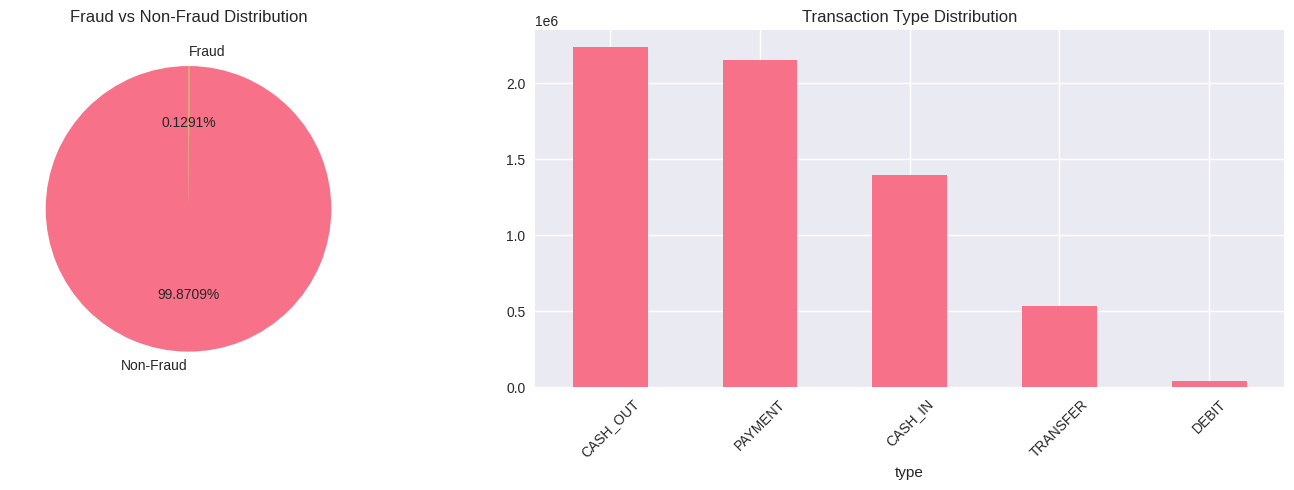

In [29]:
df = load_explore_data('/content/sample_data/Fraud.csv')


DATA CLEANING & EDA 

1. MISSING VALUES ANALYSIS
✓ No missing values found!

2. DATA TYPES AND UNIQUE VALUES


,Data Type,Unique Values,Sample Value
step,int64,743,1
type,object,5,PAYMENT
amount,float64,5316900,9839.64
nameOrig,object,6353307,C1231006815
oldbalanceOrg,float64,1845844,170136.0
newbalanceOrig,float64,2682586,160296.36
nameDest,object,2722362,M1979787155
oldbalanceDest,float64,3614697,0.0
newbalanceDest,float64,3555499,0.0
isFraud,int64,2,0



3. TRANSACTION TYPE vs FRAUD ANALYSIS
Fraud counts by transaction type:


isFraud,0,1,All
type,,,
CASH_IN,1399284,0,1399284
CASH_OUT,2233384,4116,2237500
DEBIT,41432,0,41432
PAYMENT,2151495,0,2151495
TRANSFER,528812,4097,532909
All,6354407,8213,6362620



Fraud percentage by transaction type:


isFraud,0,1
type,,
CASH_IN,100.000000,0.000000
CASH_OUT,99.816045,0.183955
DEBIT,100.000000,0.000000
PAYMENT,100.000000,0.000000
TRANSFER,99.231201,0.768799


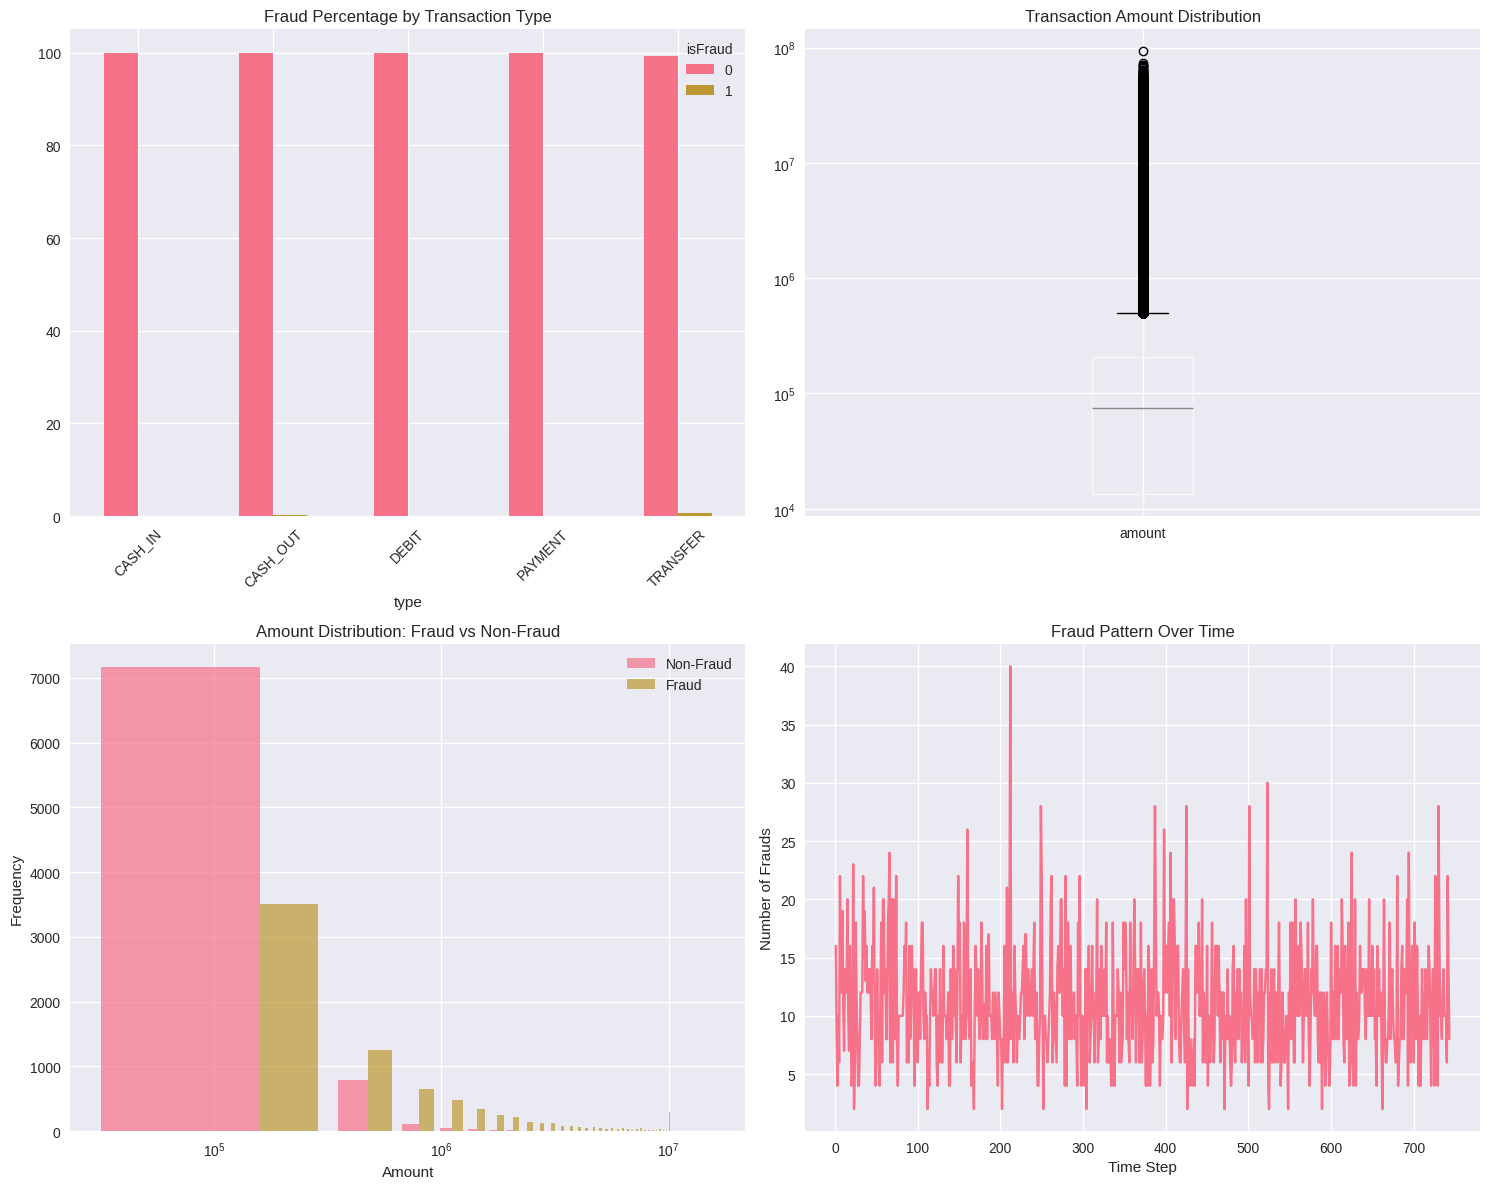


4. OUTLIER ANALYSIS


,Column,Outliers,Percentage
0,amount,338078,5.313503
1,oldbalanceOrg,1112507,17.485045
2,newbalanceOrig,1053391,16.555931
3,oldbalanceDest,786135,12.355523
4,newbalanceDest,738527,11.607278



5. CORRELATION ANALYSIS


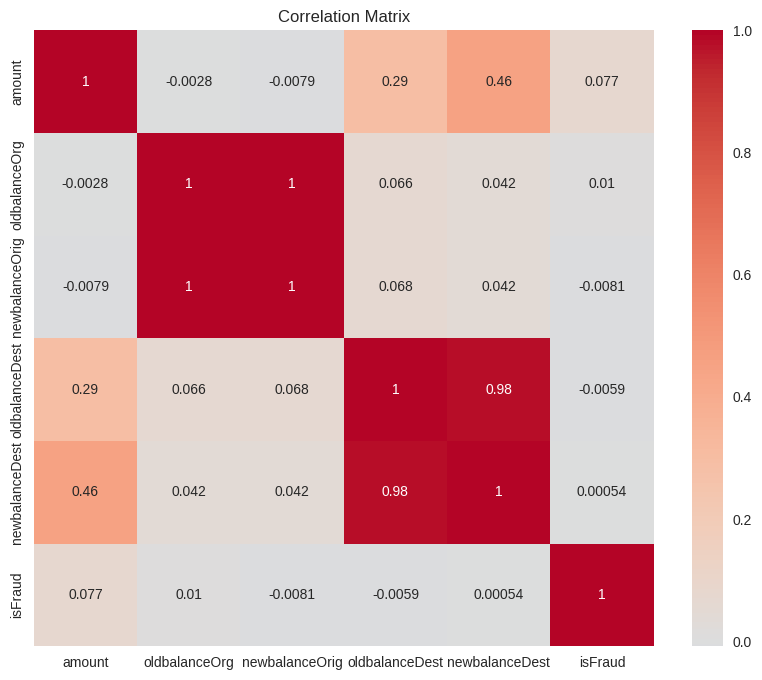

High correlations (>0.7):


,Feature 1,Feature 2,Correlation
0,oldbalanceOrg,newbalanceOrig,0.998803
1,oldbalanceDest,newbalanceDest,0.976569



6. BALANCE CONSISTENCY ANALYSIS
Origin balance inconsistencies: 5,066,425 (79.63%)
Destination balance inconsistencies (non-merchants): 1,970,616


In [30]:
df_cleaned = comprehensive_data_analysis(df)

In [31]:
df_features, encoder = advanced_feature_engineering(df_cleaned)

=== FEATURE ENGINEERING ===
Creating new features...
Original features: 11
Total features after engineering: 37

New features created (26):
 1. balance_diff_orig
 2. balance_diff_dest
 3. amount_balance_ratio_orig
 4. transaction_drains_account
 5. zero_balance_origin
 6. zero_balance_dest
 7. amount_log
 8. is_large_transaction
 9. is_round_amount
10. orig_is_customer
11. dest_is_merchant
12. dest_is_customer
13. hour_of_day
14. day_of_simulation
15. is_night_transaction
16. is_weekend
17. type_encoded
18. type_CASH_IN
19. type_CASH_OUT
20. type_DEBIT
21. type_PAYMENT
22. type_TRANSFER
23. transfer_zero_balance
24. cashout_drains_account
25. customer_to_customer
26. customer_to_merchant


In [32]:
X, y, feature_names, importance_df = prepare_model_data(df_features)


=== VARIABLE SELECTION & MODEL PREPARATION ===
Selected 32 features for modeling:

Base Features (7):
  - step
  - amount
  - oldbalanceOrg
  - newbalanceOrig
  - oldbalanceDest
  - newbalanceDest
  - type_encoded

Balance Features (3):
  - balance_diff_orig
  - balance_diff_dest
  - amount_balance_ratio_orig

Transaction Features (6):
  - transaction_drains_account
  - zero_balance_origin
  - zero_balance_dest
  - amount_log
  - is_large_transaction
  - is_round_amount

Customer Features (5):
  - orig_is_customer
  - dest_is_merchant
  - dest_is_customer
  - customer_to_customer
  - customer_to_merchant

Time Features (4):
  - hour_of_day
  - day_of_simulation
  - is_night_transaction
  - is_weekend

Interaction Features (2):
  - transfer_zero_balance
  - cashout_drains_account

Type Features (6):
  - type_encoded
  - type_CASH_IN
  - type_CASH_OUT
  - type_DEBIT
  - type_PAYMENT
  - type_TRANSFER

Performing feature importance analysis...

Top 15 Most Important Features:


,feature,importance
6,amount_balance_ratio_orig,0.331061
16,balance_diff_orig,0.197562
11,balance_diff_dest,0.101903
15,newbalanceDest,0.073290
4,oldbalanceOrg,0.068753
12,step,0.028554
8,amount,0.024687
7,hour_of_day,0.018940
23,cashout_drains_account,0.018465
2,amount_log,0.017726



Final feature set: 20 features


In [33]:
 X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

In [34]:
X_train_balanced, y_train_balanced = handle_class_imbalance(
        X_train, y_train, method='combined'
    )

=== HANDLING CLASS IMBALANCE (COMBINED) ===
Original distribution:
  Non-fraud: 5,083,526 (99.8709%)
  Fraud: 6,570 (0.1291%)
Step 1: Undersampling majority class...
Step 2: SMOTE oversampling...

Balanced distribution:
  Non-fraud: 13,140 (50.00%)
  Fraud: 13,140 (50.00%)

Dataset size change: 5,090,096 → 26,280 (-99.5%)


In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
model_results, best_model = train_multiple_models(
        X_train_scaled, y_train_balanced, X_test_scaled, y_test
    )

=== TRAINING MULTIPLE MODELS ===

Training Random Forest...
Results for Random Forest:
  Accuracy: 0.9997
  Precision: 0.8313
  Recall: 0.9988
  F1-Score: 0.9074
  AUC-ROC: 0.9999
  CV F1-Score: 0.9974 ± 0.0007

Training Gradient Boosting...


In [ ]:
evaluation_results = comprehensive_model_evaluation(
        model_results, best_model, X_test_scaled, y_test
    )

In [ ]:
fraud_analysis = analyze_fraud_patterns(df)

In [ ]:
insights, validation = generate_business_insights(
        evaluation_results['feature_importance'], fraud_analysis
    )

In [ ]:
prevention_recs = infrastructure_prevention_recommendations()

In [ ]:
success_framework = success_measurement_framework()